# CNN Model building from scratch

### Importing required libraries

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.metrics import Precision, Recall, Accuracy
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import cohen_kappa_score,log_loss
from tabulate import tabulate
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

### Declaring the Variables

In [9]:
IMAGE_SIZE = [256, 256]
BATCH_SIZE=16
FOLDS=10
SCORES_PER_FOLD=[]
CLASSES=["1-1","1-2","1-4","PURE"]

In [10]:
image_dir='/content/drive/MyDrive/Project_2_Conference_Journal_Work/BLACK_WHITE'

In [11]:
logdir='/content/drive/MyDrive/Project_2_Conference_Journal_Work/Conference_Journal_Extended_Work/Logs'

In [12]:
model_dir='/content/drive/MyDrive/Project_2_Conference_Journal_Work/Conference_Journal_Extended_Work/Models/'

In [13]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

### Fetching and Preprocessing the image files

In [14]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [15]:
image_data_set =tf.keras.utils.image_dataset_from_directory(
  image_dir,
  label_mode='int',
  seed=131,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE,
)

Found 2240 files belonging to 4 classes.


In [16]:
train_val_set=image_data_set.take(100)
test_set=image_data_set.skip(100).take(40)
print(f'Using {len(train_val_set)} sets for Training and Validation')
print(f'Using {len(test_set)} sets for Testing')

Using 100 sets for Training and Validation
Using 40 sets for Testing


In [17]:
normalized_train_val_set=train_val_set.map(lambda x,y: (normalization_layer(x), y))
normalized_testing_set=test_set.map(lambda x,y: (normalization_layer(x), y))

# image_batch, labels_batch = next(iter(normalized_training_set))      #<-----the data is fethched in this form: image batch, label batch

### Building the CNN Model

In [18]:
def Build_Model():
  model=Sequential()

  model.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=(256,256,3)))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(64, (3,3), 1, activation='relu'))
  model.add(MaxPooling2D())

  model.add(Conv2D(64, (3,3), 1, activation='relu'))
  model.add(MaxPooling2D())

  model.add(Conv2D(128, (3,3), 1, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Flatten())

  model.add(Dense(256, activation='relu'))
  model.add(Dense(4, activation='sigmoid'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

In [19]:
# Summary of the model
model=Build_Model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)      

### Peforming the 10 Fold Cross Validation

In [20]:
i=0
j=10
k=90
TFold_start=time.time()
for fold_var in range(0,FOLDS,1):
  print(f'Fold {fold_var+1}')
  print('--------------------------------------------------------------------------------------------')
  training_set1=normalized_train_val_set.take(i)
  training_set2=normalized_train_val_set.skip(i+j).take(k)
  training_set=training_set1.concatenate(training_set2)
  validation_set=normalized_train_val_set.skip(i).take(j)
  i=i+10
  j=10
  k=k-10

  model=Build_Model()
  Model_Run = model.fit(
    training_set,
    epochs=20,
    steps_per_epoch=len(training_set),
    callbacks=[tensorboard_callback]
  )
  print('\n')
  print(f'Evaluating the model')
  print('\n')
  cur_scores=model.evaluate(validation_set)
  cur_scores[0]*=100
  cur_scores[1]*=100
  cur_scores=[fold_var+1,cur_scores[0],cur_scores[1]]
  SCORES_PER_FOLD.append(cur_scores)

  model.save(model_dir+'model_'+str(fold_var+1)+'.h5')
  print('--------------------------------------------------------------------------------------------')
  tf.keras.backend.clear_session()
TFold_stop=time.time()

Fold 1
--------------------------------------------------------------------------------------------
Epoch 1/20
90/90 [==============================] - 355s 3s/step - loss: 0.6457 - accuracy: 0.7333
Epoch 2/20
90/90 [==============================] - 6s 59ms/step - loss: 0.4232 - accuracy: 0.8097
Epoch 3/20
90/90 [==============================] - 7s 60ms/step - loss: 0.3485 - accuracy: 0.8500
Epoch 4/20
90/90 [==============================] - 8s 78ms/step - loss: 0.4073 - accuracy: 0.8250
Epoch 5/20
90/90 [==============================] - 7s 64ms/step - loss: 0.3183 - accuracy: 0.8583
Epoch 6/20
90/90 [==============================] - 7s 67ms/step - loss: 0.3322 - accuracy: 0.8618
Epoch 7/20
90/90 [==============================] - 7s 63ms/step - loss: 0.3292 - accuracy: 0.8465
Epoch 8/20
90/90 [==============================] - 6s 61ms/step - loss: 0.3263 - accuracy: 0.8583
Epoch 9/20
90/90 [==============================] - 8s 80ms/step - loss: 0.2927 - accuracy: 0.8729
Epoch 10/

In [21]:
print(f'Time required for 10 Fold Cross Validation= {TFold_stop-TFold_start} seconds')

Time required for 10 Fold Cross Validation= 2496.1682317256927 seconds


In [22]:
column_headers=['Fold Number','Validation Loss(%)','Validation Accuracy(%)']
print('10 Fold Cross Validation Result')
print(tabulate(SCORES_PER_FOLD, headers=column_headers, tablefmt="grid"))

10 Fold Cross Validation Result
+---------------+----------------------+--------------------------+
|   Fold Number |   Validation Loss(%) |   Validation Accuracy(%) |
+===============+======================+==========================+
|             1 |              7.34405 |                   98.125 |
+---------------+----------------------+--------------------------+
|             2 |             18.3512  |                   92.5   |
+---------------+----------------------+--------------------------+
|             3 |             10.1492  |                   97.5   |
+---------------+----------------------+--------------------------+
|             4 |              3.29146 |                   99.375 |
+---------------+----------------------+--------------------------+
|             5 |             12.9132  |                   95     |
+---------------+----------------------+--------------------------+
|             6 |              2.44114 |                   98.75  |
+---------------

### Selecting the model with highest accuracy for training

In [23]:
max_acc=SCORES_PER_FOLD[0][2]
max_acc_index=[]
for i in range(len(SCORES_PER_FOLD)):
  if(SCORES_PER_FOLD[i][2]>max_acc):
    max_acc=SCORES_PER_FOLD[i][2]
print(f'The maximum validation accuracy is: {max_acc}')
for i in range(len(SCORES_PER_FOLD)):
  if(SCORES_PER_FOLD[i][2]==max_acc):
    max_acc_index.append(i)
print(f'The folds having {max_acc} validation accuracy are:')
for i in range(len(max_acc_index)):
  print(max_acc_index[i]+1)

result=-1
if(len(max_acc_index)>1):
    min_loss=SCORES_PER_FOLD[max_acc_index[0]][1]
    j=0
    result=max_acc_index[0]
    while(j<len(max_acc_index)):
      index=max_acc_index[j]
      if(SCORES_PER_FOLD[index][1]<min_loss):
        min_loss=SCORES_PER_FOLD[index][1]
        result=index
      j+=1
else:
  result=max_acc_index[0]
print(f'Selecting the model of fold no {result+1} for fine parameter tuning')
model=load_model(model_dir+'model_'+str(result+1)+'.h5')

The maximum validation accuracy is: 99.37499761581421
The folds having 99.37499761581421 validation accuracy are:
4
9
Selecting the model of fold no 9 for fine parameter tuning


### Training the model for fine parameter tuning

In [24]:
training_set=normalized_train_val_set.take(80)
validation_set=normalized_train_val_set.skip(80).take(20)

In [25]:
Training_start=time.time()

In [26]:
Cur_Model_Run = model.fit(
    training_set,
    validation_data=validation_set,
    epochs=30,
    steps_per_epoch=len(training_set),
    validation_steps=len(validation_set),
    callbacks=[tensorboard_callback]
  )

Epoch 1/30
80/80 [==============================] - 12s 120ms/step - loss: 0.0841 - accuracy: 0.9852 - val_loss: 0.1283 - val_accuracy: 0.9625
Epoch 2/30
80/80 [==============================] - 11s 132ms/step - loss: 0.0981 - accuracy: 0.9664 - val_loss: 0.0677 - val_accuracy: 0.9781
Epoch 3/30
80/80 [==============================] - 11s 129ms/step - loss: 0.0330 - accuracy: 0.9875 - val_loss: 0.0140 - val_accuracy: 1.0000
Epoch 4/30
80/80 [==============================] - 10s 122ms/step - loss: 0.1049 - accuracy: 0.9664 - val_loss: 0.0546 - val_accuracy: 0.9812
Epoch 5/30
80/80 [==============================] - 10s 118ms/step - loss: 0.0368 - accuracy: 0.9898 - val_loss: 0.0947 - val_accuracy: 0.9594
Epoch 6/30
80/80 [==============================] - 11s 131ms/step - loss: 0.0637 - accuracy: 0.9836 - val_loss: 0.0392 - val_accuracy: 0.9875
Epoch 7/30
80/80 [==============================] - 15s 186ms/step - loss: 0.1380 - accuracy: 0.9570 - val_loss: 0.0598 - val_accuracy: 0.9844

In [27]:
Training_stop=time.time()

In [28]:
print(f'Time required for model fine parameter tuning= {Training_stop-Training_start} seconds')

Time required for model fine parameter tuning= 416.86944341659546 seconds


### Saving the fine tuned model

In [29]:
model.save('/content/drive/MyDrive/Project_2_Conference_Journal_Work/Conference_Journal_Extended_Work/Model_fine_tuned.h5')

### Plotting the performance of the model after fine parameter tuning

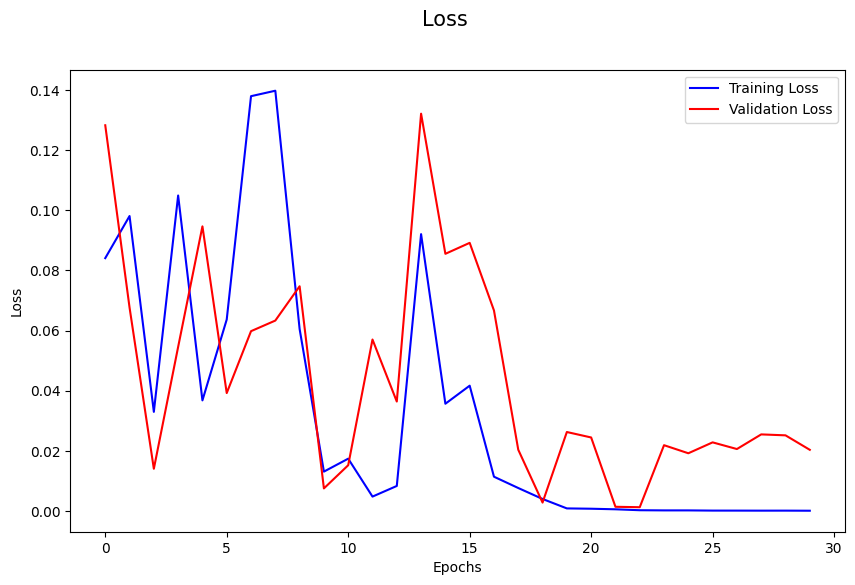

In [30]:
# Plotting the loss


fig=plt.figure(figsize=(10,6))
plt.plot(Cur_Model_Run.history['loss'], color='blue', label='Training Loss')
plt.plot(Cur_Model_Run.history['val_loss'], color='red', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
fig.suptitle('Loss',fontsize=15)
plt.legend()
plt.show()
fig.savefig('/content/drive/MyDrive/Project_2_Conference_Journal_Work/Conference_Journal_Extended_Work/Loss.eps', format='eps', dpi=600)

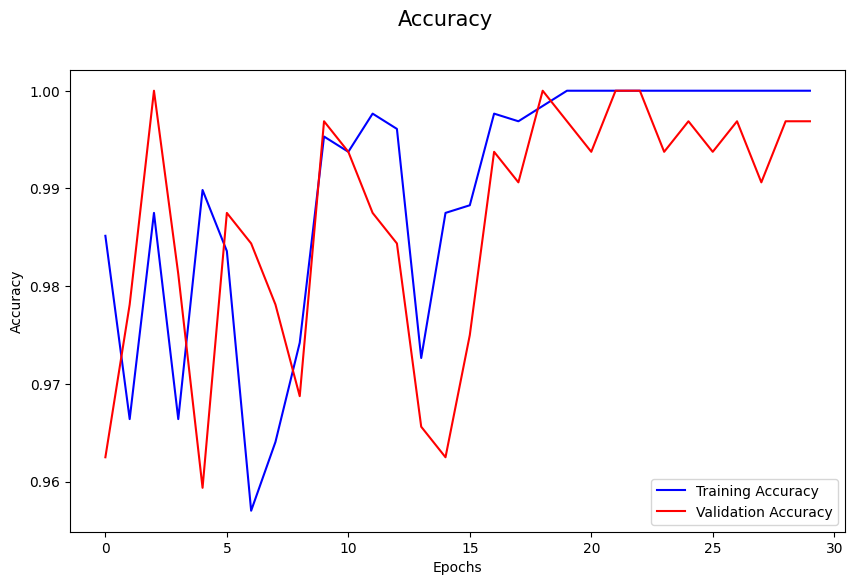

In [31]:
# Plotting the accuracy


fig=plt.figure(figsize=(10,6))
plt.plot(Cur_Model_Run.history['accuracy'], color='blue', label='Training Accuracy')
plt.plot(Cur_Model_Run.history['val_accuracy'], color='red', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
fig.suptitle('Accuracy',fontsize=15)
plt.legend()
plt.show()
fig.savefig('/content/drive/MyDrive/Project_2_Conference_Journal_Work/Conference_Journal_Extended_Work/Accuracy.eps', format='eps', dpi=600)

### Calcualting Precision, Recall, Accuracy, F Score, Cohen-Kappa Score,ROC AUC and Log-Loss Score of the Model

In [32]:
pre = Precision()
re = Recall()
acc = Accuracy()

In [33]:
True_label=[]
Predicted_label=[]
Predicted_probabilities=[]
score=[]
for images,labels in (normalized_testing_set):
  score.append(model.evaluate(images,labels))
  for it in range(len(labels)):
    True_label.append(labels[it])
  pred=model.predict(images)
  y_max=[]
  for it in range(len(pred)):
      Predicted_probabilities.append(pred[it])
      y_max.append(np.argmax(pred[it]))
      Predicted_label.append(np.argmax(pred[it]))
  pre.update_state(labels,y_max)
  re.update_state(labels,y_max)
  acc.update_state(labels,y_max)

1/1 [==============================] - 0s 27ms/step


In [34]:
f_score=(2*pre.result().numpy()*re.result().numpy())/(pre.result().numpy()+re.result().numpy())

In [35]:
kappa=cohen_kappa_score(True_label,Predicted_label)

In [36]:
True_label=np.array(True_label)
Predicted_label=np.array(Predicted_label)
Predicted_probabilities=np.array(Predicted_probabilities)

In [37]:
Binarized_True_label=label_binarize(True_label,classes=[0, 1, 2, 3])

In [38]:
#Calcualting the fpr, tpr and auc


fpr = [0] * 4
tpr = [0] * 4
roc_auc= [0] * 4
avg_roc_auc=0
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(Binarized_True_label[:, i], Predicted_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [39]:
roc_auc_details=[]
for i in range(4):
  temp=[CLASSES[i],roc_auc[i]]
  roc_auc_details.append(temp)

In [40]:
column_headers=['CLASS','ROC-AUC']
print('ROC-AUC Results')
print(tabulate(roc_auc_details, headers=column_headers, tablefmt="grid"))

ROC-AUC Results
+---------+-----------+
| CLASS   |   ROC-AUC |
+=========+===========+
| 1-1     |  0.981749 |
+---------+-----------+
| 1-2     |  0.986499 |
+---------+-----------+
| 1-4     |  0.999792 |
+---------+-----------+
| PURE    |  1        |
+---------+-----------+


In [41]:
avg_roc_auc=sum(roc_auc)/4

In [42]:
print(f'The average ROC-AUC value is: {avg_roc_auc}')

The average ROC-AUC value is: 0.9920098890494045


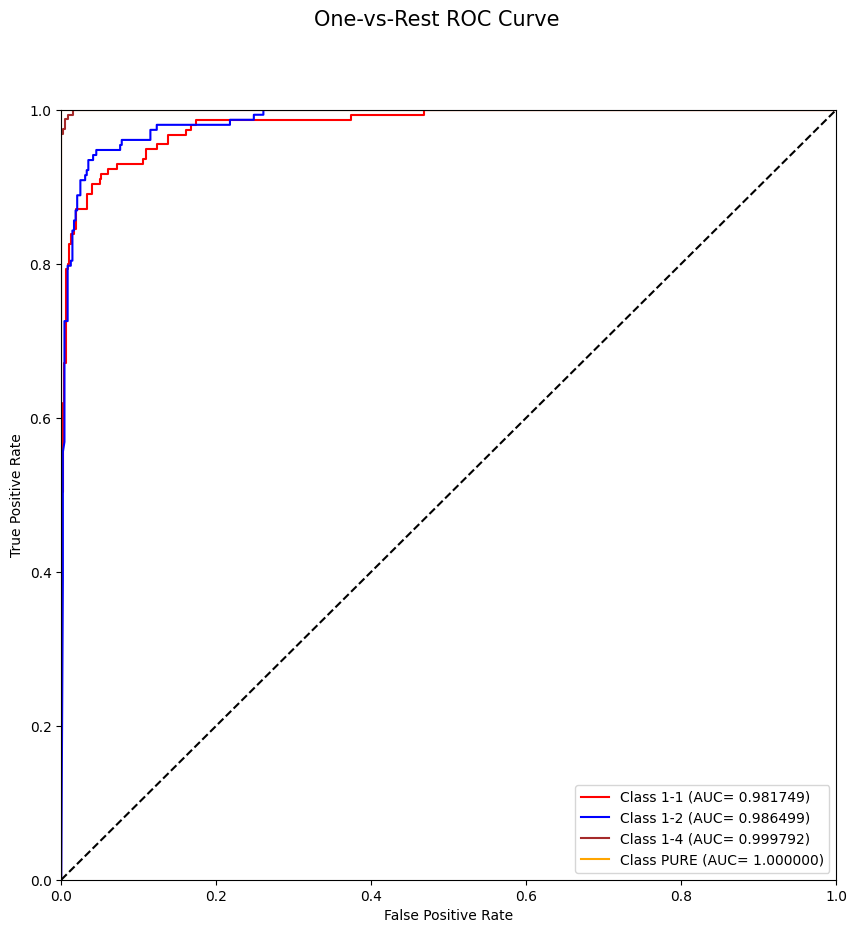

In [43]:
#Plotting the ROC Curve


fig=plt.figure(figsize=(10,10))
color=['red','blue','brown','orange']
for i in range(4):
  plt.plot(fpr[i],tpr[i],color[i],label='Class {} (AUC= {:.6F})'.format(CLASSES[i],roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('One-vs-Rest ROC Curve',fontsize=15)
plt.legend(loc='lower right')
plt.show()
fig.savefig('/content/drive/MyDrive/Project_2_Conference_Journal_Work/Conference_Journal_Extended_Work/ROC_AUC.eps', format='eps', dpi=600)

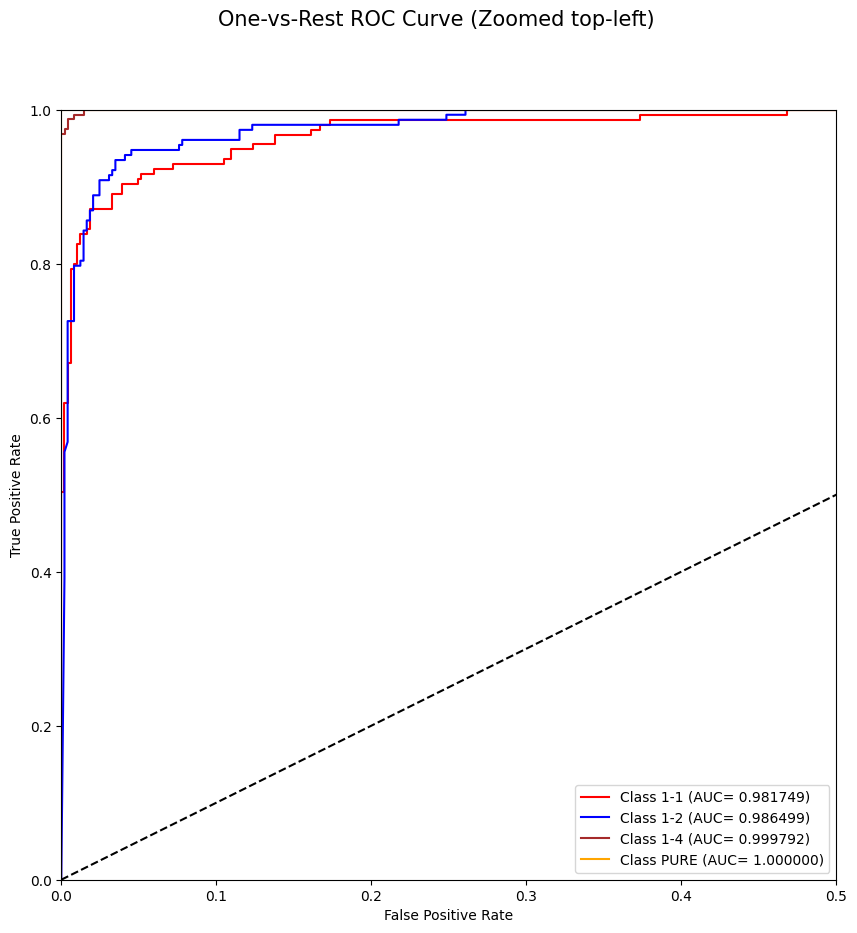

In [44]:
#Plotting the ROC Curve (Zoomed in at the top left corner)


fig=plt.figure(figsize=(10,10))
color=['red','blue','brown','orange']
for i in range(4):
  plt.plot(fpr[i],tpr[i],color[i],label='Class {} (AUC= {:.6F})'.format(CLASSES[i],roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 0.50])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('One-vs-Rest ROC Curve (Zoomed top-left)',fontsize=15)
plt.legend(loc='lower right')
plt.show()
fig.savefig('/content/drive/MyDrive/Project_2_Conference_Journal_Work/Conference_Journal_Extended_Work/ROC_AUC_Zoomed.eps', format='eps', dpi=600)

In [45]:
#Calculating the Log-loss Score (One-vs-Rest)


temp=[0]*4
loss=[0]*4
epsilon = 1e-15  # Small constant to avoid division by zero
N = Binarized_True_label.shape[0]

for i in range(4):
  # Clip predicted probabilities to avoid log(0) cases
  temp[i]= np.clip(Predicted_probabilities[:,i], epsilon, 1 - epsilon)
  # Calculate cross-entropy loss
  loss[i] = -np.sum(Binarized_True_label[:,i] * np.log(temp[i])) / N

In [46]:
log_loss_result=[]
for i in range(4):
  log_loss_result.append([CLASSES[i],loss[i]])

In [47]:
column_headers=['CLASS','LOG-LOSS VALUE']
print('Log-Loss Results')
print(tabulate(log_loss_result, headers=column_headers, tablefmt="grid"))

Log-Loss Results
+---------+------------------+
| CLASS   |   LOG-LOSS VALUE |
+=========+==================+
| 1-1     |      0.00661021  |
+---------+------------------+
| 1-2     |      0.00110034  |
+---------+------------------+
| 1-4     |      3.80304e-06 |
+---------+------------------+
| PURE    |      6.14673e-09 |
+---------+------------------+


In [48]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}, F Score: {f_score}, Cohen Kappa Score: {kappa}')

Precision: 0.9958333373069763, Recall: 0.985567033290863, Accuracy: 0.979687511920929, F Score: 0.990673588705996, Cohen Kappa Score: 0.972895932761064


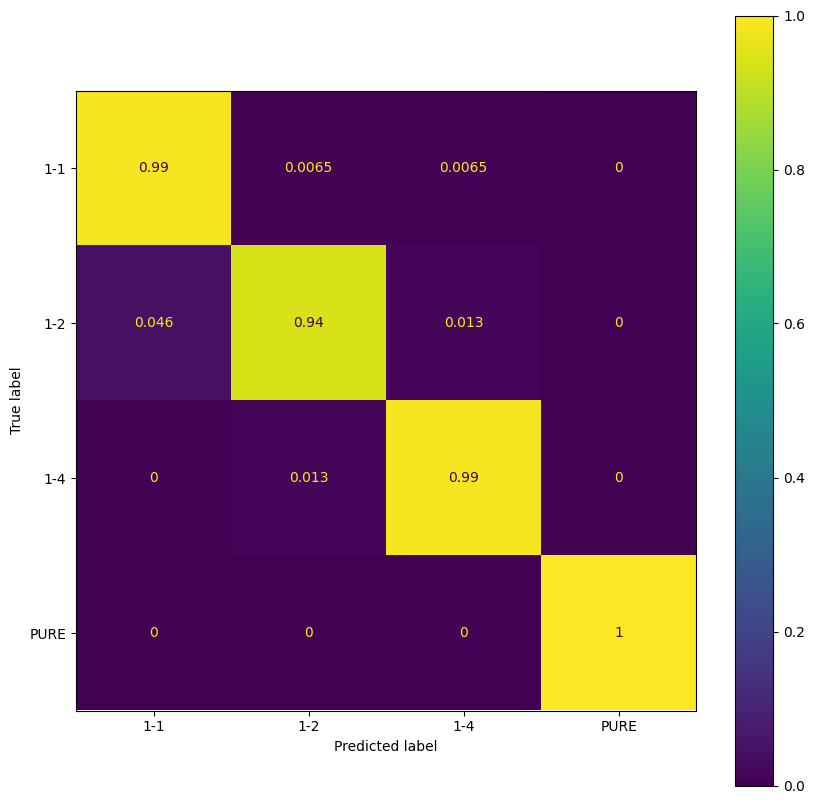

In [49]:
#Plotting the Confusion Matrix


confusion_matrix=metrics.confusion_matrix(True_label,Predicted_label,normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['1-1', '1-2','1-4','PURE'])
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
plt.show()
fig.savefig('/content/drive/MyDrive/Project_2_Conference_Journal_Work/Conference_Journal_Extended_Work/Confusion_Matrix.eps', format='eps', dpi=600)

### Demonstrating how to use the model

In [50]:
img=image.load_img('/content/drive/MyDrive/Project_2_Conference_Journal_Work/BLACK_WHITE/1-4/CR_B_DU_1-4_012.jpg',target_size=(256,256))

In [51]:
x=image.img_to_array(img)

In [52]:
x=x/255

In [53]:
x=np.expand_dims(x,axis=0)
x.shape

(1, 256, 256, 3)

In [54]:
pred=model.predict(x)

1/1 [==============================] - 0s 194ms/step


In [55]:
print(pred)

[[2.8068630e-09 9.6635222e-01 1.0000000e+00 1.5791095e-12]]


In [56]:
pred_name = CLASSES[np.argmax(pred)]
print(pred_name)

1-4


In [60]:
temp_testing_set=normalized_testing_set.take(1)

pred_start=time.time()
for (images,labels) in (temp_testing_set):
  result=model.predict(images)
pred_stop=time.time()

1/1 [==============================] - 0s 37ms/step


In [61]:
print(f'Time requrired for giving prediction on one set of {len(labels)} images= {pred_stop-pred_start}')
print(f'Average time requrired for giving prediction on one image= {(pred_stop-pred_start)/len(labels)}')

Time requrired for giving prediction on one set of 16 images= 4.397482872009277
Average time requrired for giving prediction on one image= 0.27484267950057983


# Training the VGG16 Model and evaluating the performance

In [83]:
from keras.applications import VGG16

In [84]:
vgg16_logdir='/content/drive/MyDrive/Project_2_Conference_Journal_Work/Conference_Journal_Extended_Work/VGG16_Logs'

In [85]:
vgg16_tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=vgg16_logdir)

In [86]:
vgg16_base=VGG16(weights='imagenet',include_top=False,input_shape=(256,256,3))
vgg16_model=Sequential()
vgg16_model.add(vgg16_base)
vgg16_model.add(Flatten())
vgg16_model.add(Dense(4,activation='sigmoid'))

vgg16_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [87]:
vgg16_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense_3 (Dense)             (None, 4)                 131076    
                                                                 
Total params: 14,845,764
Trainable params: 14,845,764
Non-trainable params: 0
_________________________________________________________________


In [88]:
training_set=normalized_train_val_set.take(80)
validation_set=normalized_train_val_set.skip(80).take(20)

In [89]:
vgg16_Training_start=time.time()

In [90]:
vgg16_Model_Run = vgg16_model.fit(
    training_set,
    validation_data=validation_set,
    epochs=30,
    steps_per_epoch=len(training_set),
    validation_steps=len(validation_set),
    callbacks=[vgg16_tensorboard_callback]
  )

Epoch 1/30
80/80 [==============================] - 43s 397ms/step - loss: 2.4859 - accuracy: 0.2414 - val_loss: 1.2646 - val_accuracy: 0.2375
Epoch 2/30
80/80 [==============================] - 27s 335ms/step - loss: 0.8864 - accuracy: 0.5703 - val_loss: 0.4564 - val_accuracy: 0.8156
Epoch 3/30
80/80 [==============================] - 27s 334ms/step - loss: 0.9873 - accuracy: 0.5531 - val_loss: 1.3227 - val_accuracy: 0.2594
Epoch 4/30
80/80 [==============================] - 29s 364ms/step - loss: 1.0104 - accuracy: 0.4469 - val_loss: 0.6095 - val_accuracy: 0.7219
Epoch 5/30
80/80 [==============================] - 27s 331ms/step - loss: 0.7071 - accuracy: 0.7063 - val_loss: 0.3406 - val_accuracy: 0.8500
Epoch 6/30
80/80 [==============================] - 27s 330ms/step - loss: 0.4259 - accuracy: 0.8094 - val_loss: 0.3513 - val_accuracy: 0.8781
Epoch 7/30
80/80 [==============================] - 27s 334ms/step - loss: 0.3488 - accuracy: 0.8469 - val_loss: 0.2978 - val_accuracy: 0.8719

In [91]:
vgg16_Training_stop=time.time()

In [92]:
print(f'Time required for VGG16 model training= {vgg16_Training_stop-vgg16_Training_start} seconds')

Time required for VGG16 model training= 1047.718412399292 seconds


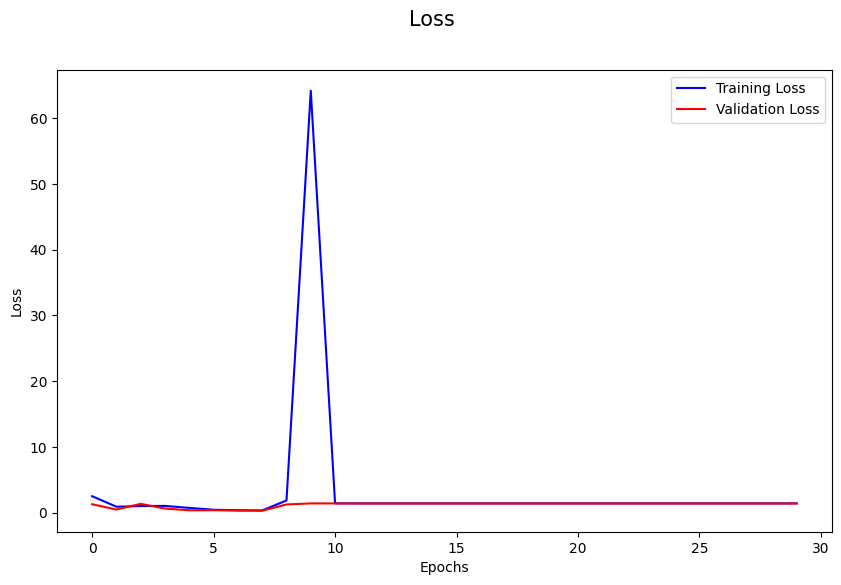

In [93]:
# Plotting the loss


fig=plt.figure(figsize=(10,6))
plt.plot(vgg16_Model_Run.history['loss'], color='blue', label='Training Loss')
plt.plot(vgg16_Model_Run.history['val_loss'], color='red', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
fig.suptitle('Loss',fontsize=15)
plt.legend()
plt.show()
fig.savefig('/content/drive/MyDrive/Project_2_Conference_Journal_Work/Conference_Journal_Extended_Work/VGG16_Loss.eps', format='eps', dpi=600)

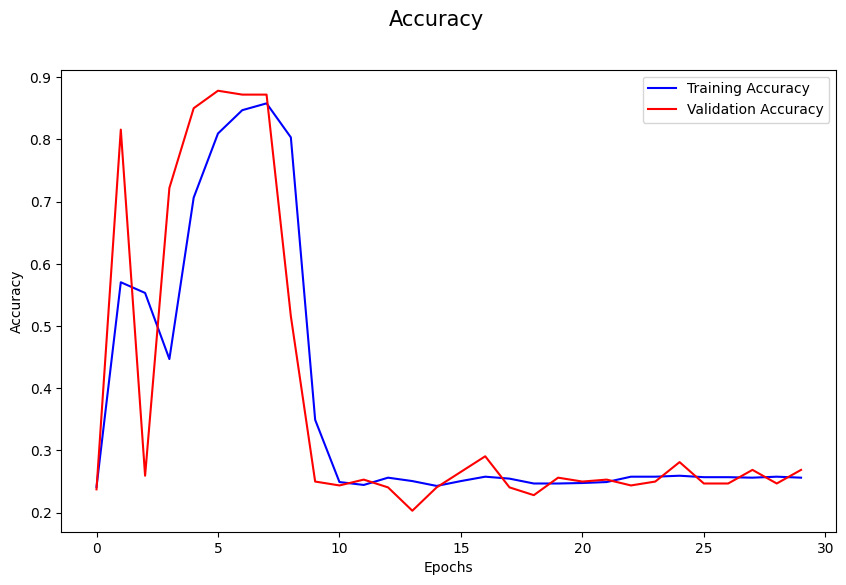

In [94]:
# Plotting the accuracy


fig=plt.figure(figsize=(10,6))
plt.plot(vgg16_Model_Run.history['accuracy'], color='blue', label='Training Accuracy')
plt.plot(vgg16_Model_Run.history['val_accuracy'], color='red', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
fig.suptitle('Accuracy',fontsize=15)
plt.legend()
plt.show()
fig.savefig('/content/drive/MyDrive/Project_2_Conference_Journal_Work/Conference_Journal_Extended_Work/VGG16_Accuracy.eps', format='eps', dpi=600)

In [95]:
# Calculating the Precision, Recall, Accuracy

pre = Precision()
re = Recall()
acc = Accuracy()

In [96]:
True_label=[]
Predicted_label=[]
Predicted_probabilities=[]
score=[]
for images,labels in (normalized_testing_set):
  score.append(vgg16_model.evaluate(images,labels))
  for it in range(len(labels)):
    True_label.append(labels[it])
  pred=vgg16_model.predict(images)
  y_max=[]
  for it in range(len(pred)):
      Predicted_probabilities.append(pred[it])
      y_max.append(np.argmax(pred[it]))
      Predicted_label.append(np.argmax(pred[it]))
  pre.update_state(labels,y_max)
  re.update_state(labels,y_max)
  acc.update_state(labels,y_max)

1/1 [==============================] - 0s 38ms/step


In [97]:
f_score=(2*pre.result().numpy()*re.result().numpy())/(pre.result().numpy()+re.result().numpy())

<ipython-input-97-3ecfc2c26591>:1: RuntimeWarning: invalid value encountered in double_scalars
  f_score=(2*pre.result().numpy()*re.result().numpy())/(pre.result().numpy()+re.result().numpy())


In [98]:
kappa=cohen_kappa_score(True_label,Predicted_label)

In [99]:
True_label=np.array(True_label)
Predicted_label=np.array(Predicted_label)
Predicted_probabilities=np.array(Predicted_probabilities)

In [100]:
Binarized_True_label=label_binarize(True_label,classes=[0, 1, 2, 3])

In [101]:
#Calcualting the fpr, tpr and auc


fpr = [0] * 4
tpr = [0] * 4
roc_auc= [0] * 4
avg_roc_auc=0
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(Binarized_True_label[:, i], Predicted_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [102]:
roc_auc_details=[]
for i in range(4):
  temp=[CLASSES[i],roc_auc[i]]
  roc_auc_details.append(temp)

In [103]:
column_headers=['CLASS','ROC-AUC']
print('ROC-AUC Results')
print(tabulate(roc_auc_details, headers=column_headers, tablefmt="grid"))

ROC-AUC Results
+---------+-----------+
| CLASS   |   ROC-AUC |
+=========+===========+
| 1-1     |       0.5 |
+---------+-----------+
| 1-2     |       0.5 |
+---------+-----------+
| 1-4     |       0.5 |
+---------+-----------+
| PURE    |       0.5 |
+---------+-----------+


In [104]:
avg_roc_auc=sum(roc_auc)/4

In [105]:
print(f'The average ROC-AUC value is: {avg_roc_auc}')

The average ROC-AUC value is: 0.5


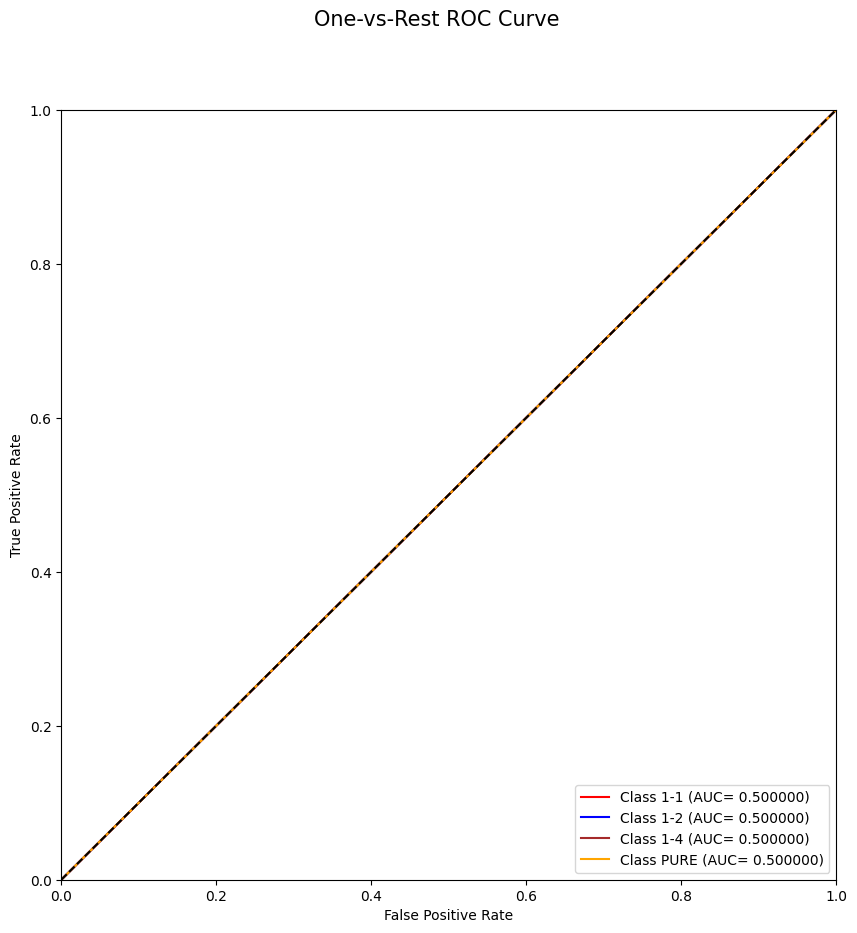

In [106]:
#Plotting the ROC Curve


fig=plt.figure(figsize=(10,10))
color=['red','blue','brown','orange']
for i in range(4):
  plt.plot(fpr[i],tpr[i],color[i],label='Class {} (AUC= {:.6F})'.format(CLASSES[i],roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('One-vs-Rest ROC Curve',fontsize=15)
plt.legend(loc='lower right')
plt.show()
fig.savefig('/content/drive/MyDrive/Project_2_Conference_Journal_Work/Conference_Journal_Extended_Work/VGG16_ROC_AUC.eps', format='eps', dpi=600)

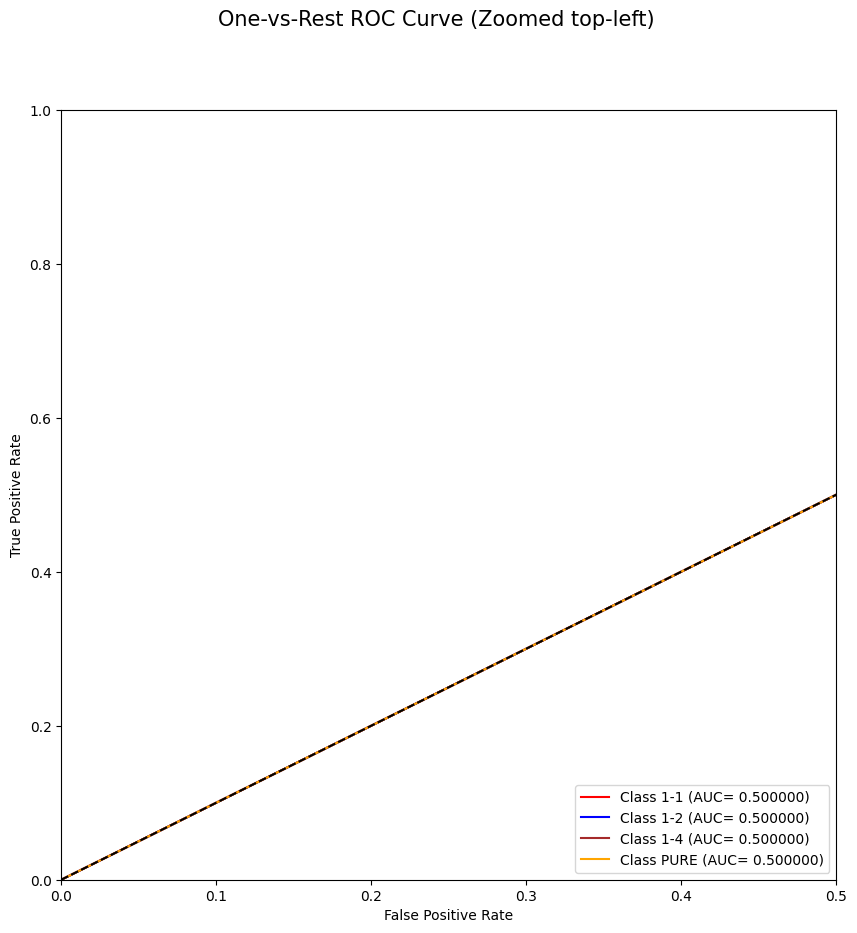

In [107]:
#Plotting the ROC Curve (Zoomed in at the top left corner)


fig=plt.figure(figsize=(10,10))
color=['red','blue','brown','orange']
for i in range(4):
  plt.plot(fpr[i],tpr[i],color[i],label='Class {} (AUC= {:.6F})'.format(CLASSES[i],roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 0.50])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('One-vs-Rest ROC Curve (Zoomed top-left)',fontsize=15)
plt.legend(loc='lower right')
plt.show()
fig.savefig('/content/drive/MyDrive/Project_2_Conference_Journal_Work/Conference_Journal_Extended_Work/VGG16_ROC_AUC_Zoomed.eps', format='eps', dpi=600)

In [108]:
#Calculating the Log-loss Score (One-vs-Rest)


temp=[0]*4
loss=[0]*4
epsilon = 1e-15  # Small constant to avoid division by zero
N = Binarized_True_label.shape[0]

for i in range(4):
  # Clip predicted probabilities to avoid log(0) cases
  temp[i]= np.clip(Predicted_probabilities[:,i], epsilon, 1 - epsilon)
  # Calculate cross-entropy loss
  loss[i] = -np.sum(Binarized_True_label[:,i] * np.log(temp[i])) / N

In [109]:
log_loss_result=[]
for i in range(4):
  log_loss_result.append([CLASSES[i],loss[i]])

In [110]:
column_headers=['CLASS','LOG-LOSS VALUE']
print('Log-Loss Results')
print(tabulate(log_loss_result, headers=column_headers, tablefmt="grid"))

Log-Loss Results
+---------+------------------+
| CLASS   |   LOG-LOSS VALUE |
+=========+==================+
| 1-1     |         0.161255 |
+---------+------------------+
| 1-2     |         0.16885  |
+---------+------------------+
| 1-4     |         0.172355 |
+---------+------------------+
| PURE    |         0.186712 |
+---------+------------------+


In [111]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}, F Score: {f_score}, Cohen Kappa Score: {kappa}')

Precision: 0.0, Recall: 0.0, Accuracy: 0.23906250298023224, F Score: nan, Cohen Kappa Score: 0.0


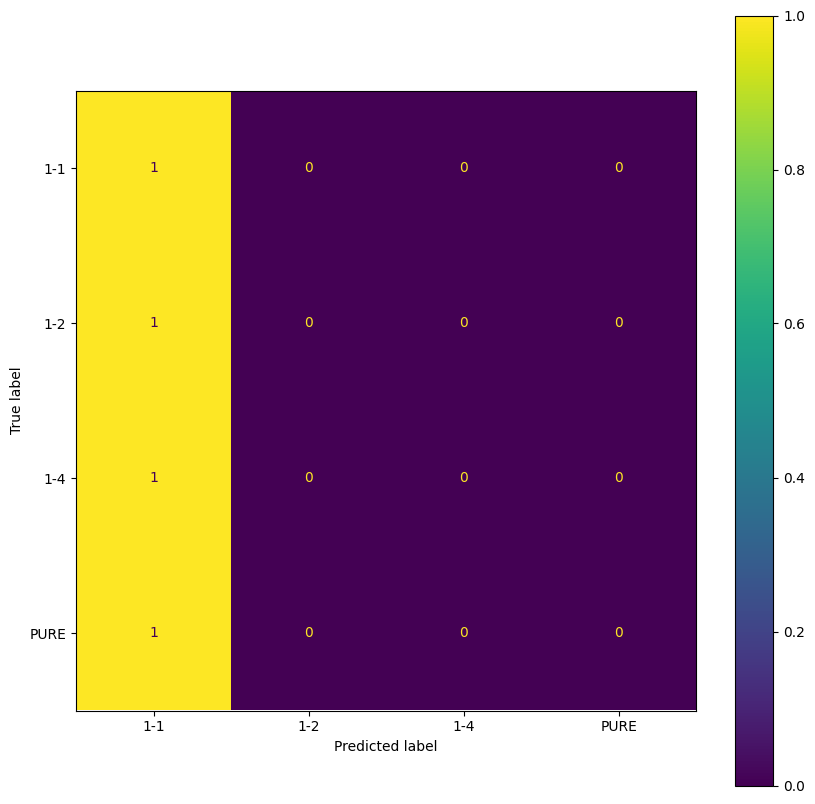

In [112]:
#Plotting the Confusion Matrix


confusion_matrix=metrics.confusion_matrix(True_label,Predicted_label,normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['1-1', '1-2','1-4','PURE'])
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
plt.show()
fig.savefig('/content/drive/MyDrive/Project_2_Conference_Journal_Work/Conference_Journal_Extended_Work/VGG16_Confusion_Matrix.eps', format='eps', dpi=600)

# Training the  MobileNetV2 Model and evaluating the performance

In [121]:
from keras.applications import MobileNetV2

In [122]:
mobilenetv2_logdir='/content/drive/MyDrive/Project_2_Conference_Journal_Work/Conference_Journal_Extended_Work/MOBILENETV2_Logs'

In [123]:
mobilenetv2_tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=mobilenetv2_logdir)

In [124]:
mobilenetv2_base=MobileNetV2(weights='imagenet',include_top=False,input_shape=(256,256,3))
mobilenetv2_model=Sequential()
mobilenetv2_model.add(mobilenetv2_base)
mobilenetv2_model.add(Flatten())
mobilenetv2_model.add(Dense(4,activation='sigmoid'))

mobilenetv2_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [125]:
mobilenetv2_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 81920)             0         
                                                                 
 dense_5 (Dense)             (None, 4)                 327684    
                                                                 
Total params: 2,585,668
Trainable params: 2,551,556
Non-trainable params: 34,112
_________________________________________________________________


In [126]:
training_set=normalized_train_val_set.take(80)
validation_set=normalized_train_val_set.skip(80).take(20)

In [127]:
mobilenetv2_Training_start=time.time()

In [128]:
mobilenetv2_Model_Run=mobilenetv2_model.fit(
    training_set,
    validation_data=validation_set,
    epochs=30,
    steps_per_epoch=len(training_set),
    validation_steps=len(validation_set),
    callbacks=[mobilenetv2_tensorboard_callback]
)

Epoch 1/30
80/80 [==============================] - 49s 183ms/step - loss: 2.1932 - accuracy: 0.6594 - val_loss: 55.3063 - val_accuracy: 0.3313
Epoch 2/30
80/80 [==============================] - 14s 171ms/step - loss: 2.6984 - accuracy: 0.6734 - val_loss: 142.0045 - val_accuracy: 0.2688
Epoch 3/30
80/80 [==============================] - 14s 168ms/step - loss: 3.5737 - accuracy: 0.6812 - val_loss: 182.4909 - val_accuracy: 0.2219
Epoch 4/30
80/80 [==============================] - 14s 173ms/step - loss: 2.0951 - accuracy: 0.6617 - val_loss: 207.6784 - val_accuracy: 0.2500
Epoch 5/30
80/80 [==============================] - 14s 167ms/step - loss: 1.2214 - accuracy: 0.7352 - val_loss: 269.9059 - val_accuracy: 0.2406
Epoch 6/30
80/80 [==============================] - 14s 170ms/step - loss: 0.5699 - accuracy: 0.7836 - val_loss: 179.1509 - val_accuracy: 0.2562
Epoch 7/30
80/80 [==============================] - 14s 172ms/step - loss: 0.4205 - accuracy: 0.8273 - val_loss: 144.5796 - val_acc

In [129]:
mobilenetv2_Training_stop=time.time()

In [130]:
print(f'Time required for MOBILENETV2 model training= {mobilenetv2_Training_stop-mobilenetv2_Training_start} seconds')

Time required for MOBILENETV2 model training= 533.603658914566 seconds


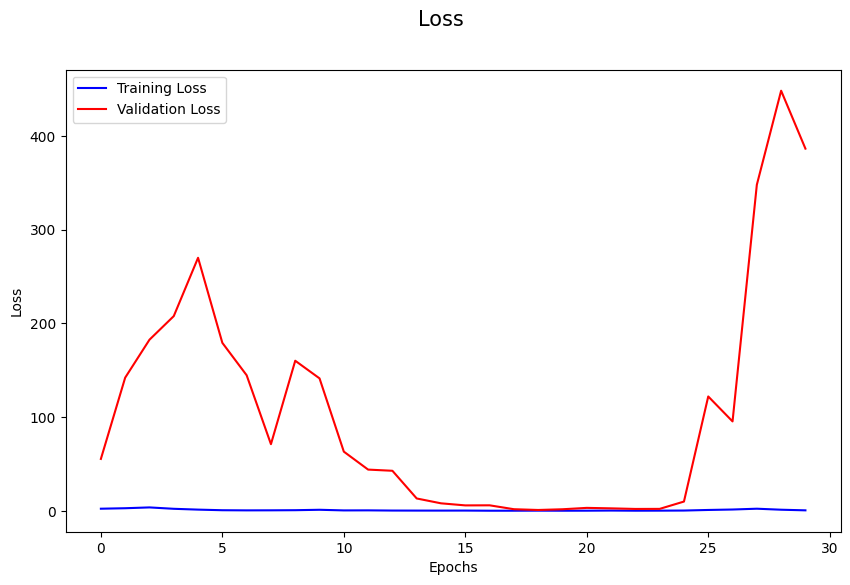

In [131]:
# Plotting the loss


fig=plt.figure(figsize=(10,6))
plt.plot(mobilenetv2_Model_Run.history['loss'], color='blue', label='Training Loss')
plt.plot(mobilenetv2_Model_Run.history['val_loss'], color='red', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
fig.suptitle('Loss',fontsize=15)
plt.legend()
plt.show()
fig.savefig('/content/drive/MyDrive/Project_2_Conference_Journal_Work/Conference_Journal_Extended_Work/MOBILENETV2_Loss.eps', format='eps', dpi=600)

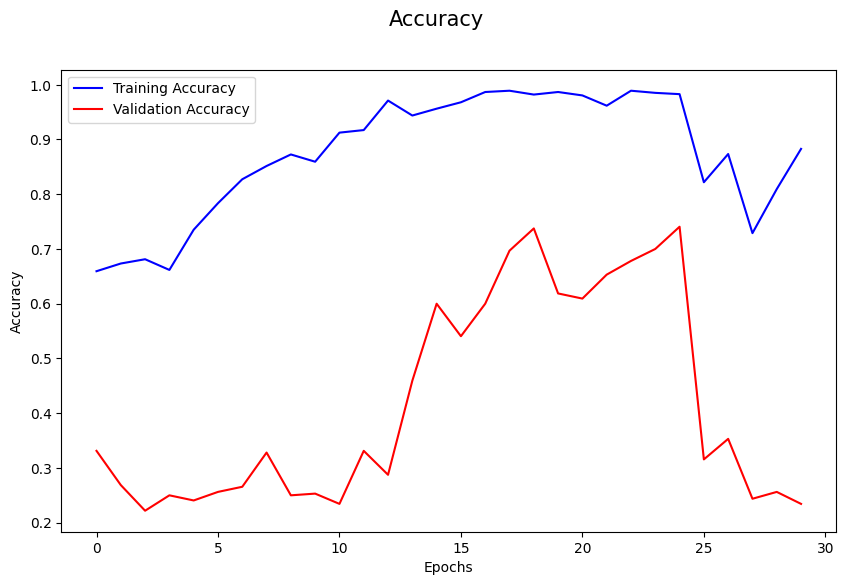

In [132]:
# Plotting the accuracy


fig=plt.figure(figsize=(10,6))
plt.plot(mobilenetv2_Model_Run.history['accuracy'], color='blue', label='Training Accuracy')
plt.plot(mobilenetv2_Model_Run.history['val_accuracy'], color='red', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
fig.suptitle('Accuracy',fontsize=15)
plt.legend()
plt.show()
fig.savefig('/content/drive/MyDrive/Project_2_Conference_Journal_Work/Conference_Journal_Extended_Work/MOBILENETV2_Accuracy.eps', format='eps', dpi=600)

In [133]:
# Calculating the Precision, Recall, Accuracy

pre = Precision()
re = Recall()
acc = Accuracy()

In [134]:
True_label=[]
Predicted_label=[]
Predicted_probabilities=[]
score=[]
for images,labels in (normalized_testing_set):
  score.append(mobilenetv2_model.evaluate(images,labels))
  for it in range(len(labels)):
    True_label.append(labels[it])
  pred=mobilenetv2_model.predict(images)
  y_max=[]
  for it in range(len(pred)):
      Predicted_probabilities.append(pred[it])
      y_max.append(np.argmax(pred[it]))
      Predicted_label.append(np.argmax(pred[it]))
  pre.update_state(labels,y_max)
  re.update_state(labels,y_max)
  acc.update_state(labels,y_max)

1/1 [==============================] - 0s 47ms/step


In [135]:
f_score=(2*pre.result().numpy()*re.result().numpy())/(pre.result().numpy()+re.result().numpy())

In [136]:
kappa=cohen_kappa_score(True_label,Predicted_label)

In [137]:
True_label=np.array(True_label)
Predicted_label=np.array(Predicted_label)
Predicted_probabilities=np.array(Predicted_probabilities)

In [138]:
Binarized_True_label=label_binarize(True_label,classes=[0, 1, 2, 3])

In [139]:
#Calcualting the fpr, tpr and auc


fpr = [0] * 4
tpr = [0] * 4
roc_auc= [0] * 4
avg_roc_auc=0
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(Binarized_True_label[:, i], Predicted_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [140]:
roc_auc_details=[]
for i in range(4):
  temp=[CLASSES[i],roc_auc[i]]
  roc_auc_details.append(temp)

In [141]:
column_headers=['CLASS','ROC-AUC']
print('ROC-AUC Results')
print(tabulate(roc_auc_details, headers=column_headers, tablefmt="grid"))

ROC-AUC Results
+---------+-----------+
| CLASS   |   ROC-AUC |
+=========+===========+
| 1-1     |  0.61447  |
+---------+-----------+
| 1-2     |  0.5      |
+---------+-----------+
| 1-4     |  0.489533 |
+---------+-----------+
| PURE    |  0.5      |
+---------+-----------+


In [142]:
avg_roc_auc=sum(roc_auc)/4

In [143]:
print(f'The average ROC-AUC value is: {avg_roc_auc}')

The average ROC-AUC value is: 0.526000786335509


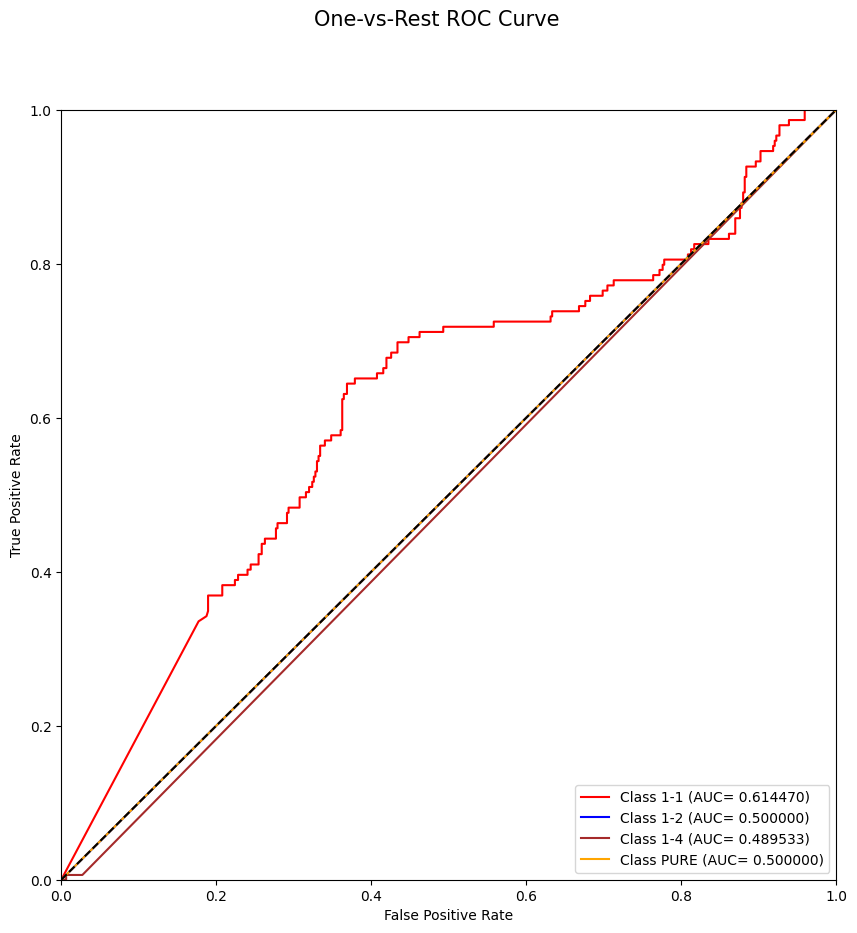

In [144]:
#Plotting the ROC Curve


fig=plt.figure(figsize=(10,10))
color=['red','blue','brown','orange']
for i in range(4):
  plt.plot(fpr[i],tpr[i],color[i],label='Class {} (AUC= {:.6F})'.format(CLASSES[i],roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('One-vs-Rest ROC Curve',fontsize=15)
plt.legend(loc='lower right')
plt.show()
fig.savefig('/content/drive/MyDrive/Project_2_Conference_Journal_Work/Conference_Journal_Extended_Work/MOBILENETV2_ROC_AUC.eps', format='eps', dpi=600)

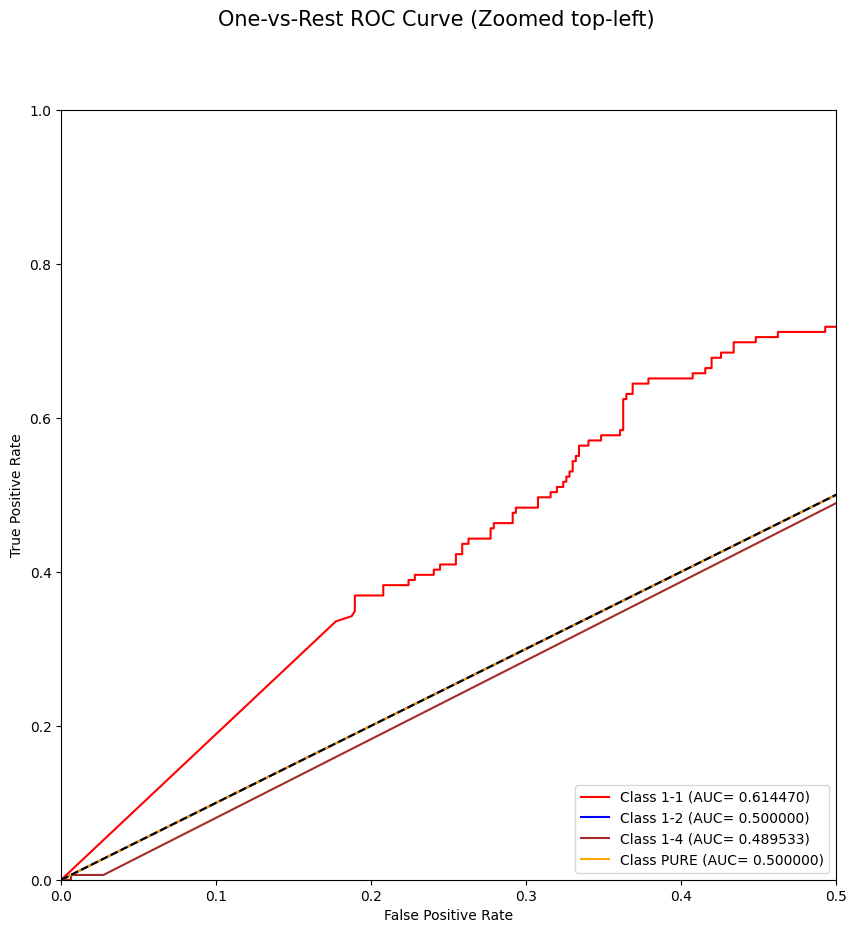

In [145]:
#Plotting the ROC Curve (Zoomed in at the top left corner)


fig=plt.figure(figsize=(10,10))
color=['red','blue','brown','orange']
for i in range(4):
  plt.plot(fpr[i],tpr[i],color[i],label='Class {} (AUC= {:.6F})'.format(CLASSES[i],roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 0.50])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('One-vs-Rest ROC Curve (Zoomed top-left)',fontsize=15)
plt.legend(loc='lower right')
plt.show()
fig.savefig('/content/drive/MyDrive/Project_2_Conference_Journal_Work/Conference_Journal_Extended_Work/MOBILENETV2_ROC_AUC_Zoomed.eps', format='eps', dpi=600)

In [146]:
#Calculating the Log-loss Score (One-vs-Rest)


temp=[0]*4
loss=[0]*4
epsilon = 1e-15  # Small constant to avoid division by zero
N = Binarized_True_label.shape[0]

for i in range(4):
  # Clip predicted probabilities to avoid log(0) cases
  temp[i]= np.clip(Predicted_probabilities[:,i], epsilon, 1 - epsilon)
  # Calculate cross-entropy loss
  loss[i] = -np.sum(Binarized_True_label[:,i] * np.log(temp[i])) / N

In [147]:
log_loss_result=[]
for i in range(4):
  log_loss_result.append([CLASSES[i],loss[i]])

In [148]:
column_headers=['CLASS','LOG-LOSS VALUE']
print('Log-Loss Results')
print(tabulate(log_loss_result, headers=column_headers, tablefmt="grid"))

Log-Loss Results
+---------+------------------+
| CLASS   |   LOG-LOSS VALUE |
+=========+==================+
| 1-1     |          1.83965 |
+---------+------------------+
| 1-2     |          8.63469 |
+---------+------------------+
| 1-4     |          8.74263 |
+---------+------------------+
| PURE    |         -0       |
+---------+------------------+


In [149]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}, F Score: {f_score}, Cohen Kappa Score: {kappa}')

Precision: 0.8031809329986572, Recall: 0.8228105902671814, Accuracy: 0.3421874940395355, F Score: 0.8128772430731718, Cohen Kappa Score: 0.11420869222171093


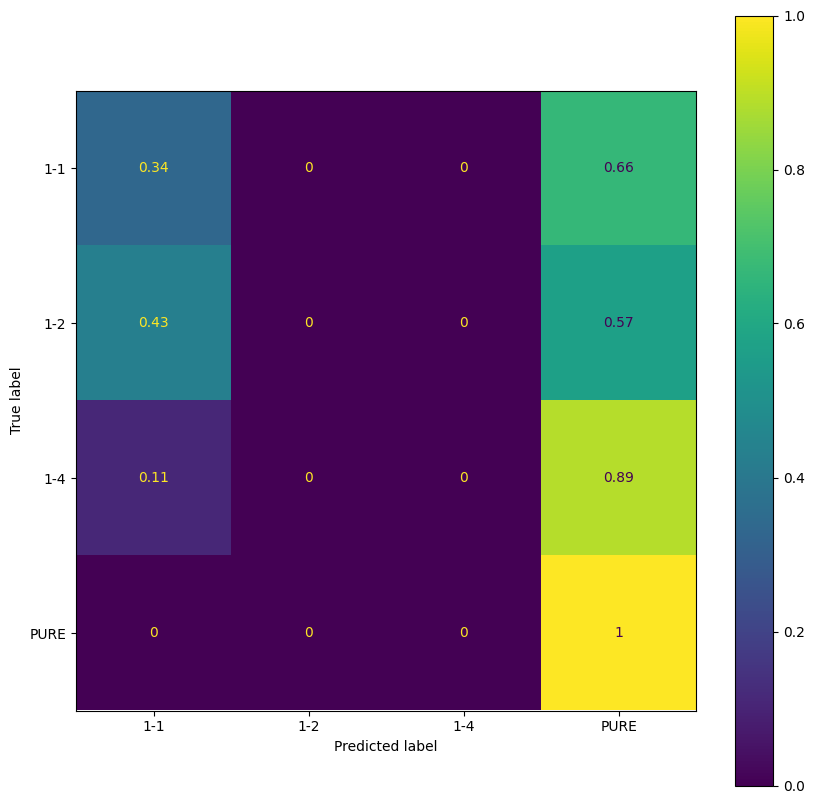

In [150]:
#Plotting the Confusion Matrix


confusion_matrix=metrics.confusion_matrix(True_label,Predicted_label,normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['1-1', '1-2','1-4','PURE'])
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
plt.show()
fig.savefig('/content/drive/MyDrive/Project_2_Conference_Journal_Work/Conference_Journal_Extended_Work/MOBILENETV2_Confusion_Matrix.eps', format='eps', dpi=600)

# Training the ResNet50 Model and evaluating the performance

In [151]:
from keras.applications import ResNet50

In [152]:
resnet50_logdir='/content/drive/MyDrive/Project_2_Conference_Journal_Work/Conference_Journal_Extended_Work/RESNET50_Logs'

In [153]:
resnet50_tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=resnet50_logdir)

In [154]:
resnet50_base=ResNet50(weights='imagenet',include_top=False,input_shape=(256,256,3))
resnet50_model=Sequential()
resnet50_model.add(resnet50_base)
resnet50_model.add(Flatten())
resnet50_model.add(Dense(4,activation='sigmoid'))

resnet50_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

94765736/94765736 [==============================] - 3s 0us/step


In [155]:
resnet50_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 131072)            0         
                                                                 
 dense_6 (Dense)             (None, 4)                 524292    
                                                                 
Total params: 24,112,004
Trainable params: 24,058,884
Non-trainable params: 53,120
_________________________________________________________________


In [156]:
training_set=normalized_train_val_set.take(80)
validation_set=normalized_train_val_set.skip(80).take(20)

In [157]:
resnet50_Training_start=time.time()

In [158]:
resnet50_Model_Run=resnet50_model.fit(
    training_set,
    validation_data=validation_set,
    epochs=30,
    steps_per_epoch=len(training_set),
    validation_steps=len(validation_set),
    callbacks=[resnet50_tensorboard_callback]
)

Epoch 1/30
80/80 [==============================] - 68s 288ms/step - loss: 5.3638 - accuracy: 0.6664 - val_loss: 3395926.7500 - val_accuracy: 0.2406
Epoch 2/30
80/80 [==============================] - 22s 272ms/step - loss: 2.4996 - accuracy: 0.7273 - val_loss: 1.3864 - val_accuracy: 0.2469
Epoch 3/30
80/80 [==============================] - 24s 291ms/step - loss: 1.5294 - accuracy: 0.7836 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 4/30
80/80 [==============================] - 23s 283ms/step - loss: 1.6033 - accuracy: 0.7977 - val_loss: 1.3869 - val_accuracy: 0.2344
Epoch 5/30
80/80 [==============================] - 28s 342ms/step - loss: 2.1243 - accuracy: 0.8227 - val_loss: 1.3888 - val_accuracy: 0.2125
Epoch 6/30
80/80 [==============================] - 27s 340ms/step - loss: 1.4659 - accuracy: 0.8344 - val_loss: 1.3873 - val_accuracy: 0.2594
Epoch 7/30
80/80 [==============================] - 23s 287ms/step - loss: 0.5424 - accuracy: 0.8320 - val_loss: 1.3894 - val_accuracy: 

In [159]:
resnet50_Training_stop=time.time()

In [160]:
print(f'Time required for RESNET50 model training= {resnet50_Training_stop-resnet50_Training_start} seconds')

Time required for RESNET50 model training= 982.4409837722778 seconds


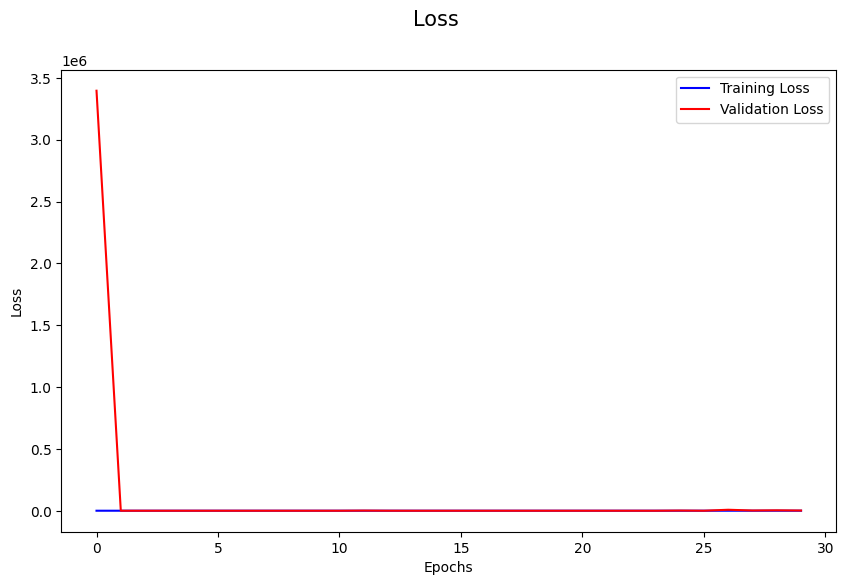

In [161]:
# Plotting the loss


fig=plt.figure(figsize=(10,6))
plt.plot(resnet50_Model_Run.history['loss'], color='blue', label='Training Loss')
plt.plot(resnet50_Model_Run.history['val_loss'], color='red', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
fig.suptitle('Loss',fontsize=15)
plt.legend()
plt.show()
fig.savefig('/content/drive/MyDrive/Project_2_Conference_Journal_Work/Conference_Journal_Extended_Work/RESNET50_Loss.eps', format='eps', dpi=600)

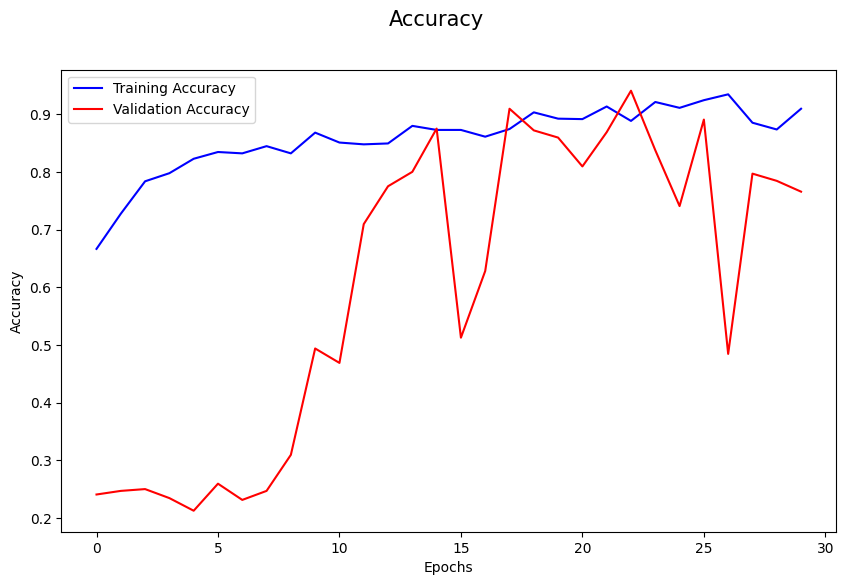

In [162]:
# Plotting the accuracy


fig=plt.figure(figsize=(10,6))
plt.plot(resnet50_Model_Run.history['accuracy'], color='blue', label='Training Accuracy')
plt.plot(resnet50_Model_Run.history['val_accuracy'], color='red', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
fig.suptitle('Accuracy',fontsize=15)
plt.legend()
plt.show()
fig.savefig('/content/drive/MyDrive/Project_2_Conference_Journal_Work/Conference_Journal_Extended_Work/RESNET50_Accuracy.eps', format='eps', dpi=600)

In [163]:
# Calculating the Precision, Recall, Accuracy

pre = Precision()
re = Recall()
acc = Accuracy()

In [164]:
True_label=[]
Predicted_label=[]
Predicted_probabilities=[]
score=[]
for images,labels in (normalized_testing_set):
  score.append(resnet50_model.evaluate(images,labels))
  for it in range(len(labels)):
    True_label.append(labels[it])
  pred=resnet50_model.predict(images)
  y_max=[]
  for it in range(len(pred)):
      Predicted_probabilities.append(pred[it])
      y_max.append(np.argmax(pred[it]))
      Predicted_label.append(np.argmax(pred[it]))
  pre.update_state(labels,y_max)
  re.update_state(labels,y_max)
  acc.update_state(labels,y_max)

1/1 [==============================] - 0s 36ms/step


In [165]:
f_score=(2*pre.result().numpy()*re.result().numpy())/(pre.result().numpy()+re.result().numpy())

In [166]:
kappa=cohen_kappa_score(True_label,Predicted_label)

In [167]:
True_label=np.array(True_label)
Predicted_label=np.array(Predicted_label)
Predicted_probabilities=np.array(Predicted_probabilities)

In [168]:
Binarized_True_label=label_binarize(True_label,classes=[0, 1, 2, 3])

In [169]:
#Calcualting the fpr, tpr and auc


fpr = [0] * 4
tpr = [0] * 4
roc_auc= [0] * 4
avg_roc_auc=0
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(Binarized_True_label[:, i], Predicted_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [170]:
roc_auc_details=[]
for i in range(4):
  temp=[CLASSES[i],roc_auc[i]]
  roc_auc_details.append(temp)

In [171]:
column_headers=['CLASS','ROC-AUC']
print('ROC-AUC Results')
print(tabulate(roc_auc_details, headers=column_headers, tablefmt="grid"))

ROC-AUC Results
+---------+-----------+
| CLASS   |   ROC-AUC |
+=========+===========+
| 1-1     |  0.591834 |
+---------+-----------+
| 1-2     |  0.709278 |
+---------+-----------+
| 1-4     |  0.99424  |
+---------+-----------+
| PURE    |  0.891343 |
+---------+-----------+


In [172]:
avg_roc_auc=sum(roc_auc)/4

In [173]:
print(f'The average ROC-AUC value is: {avg_roc_auc}')

The average ROC-AUC value is: 0.7966739392243164


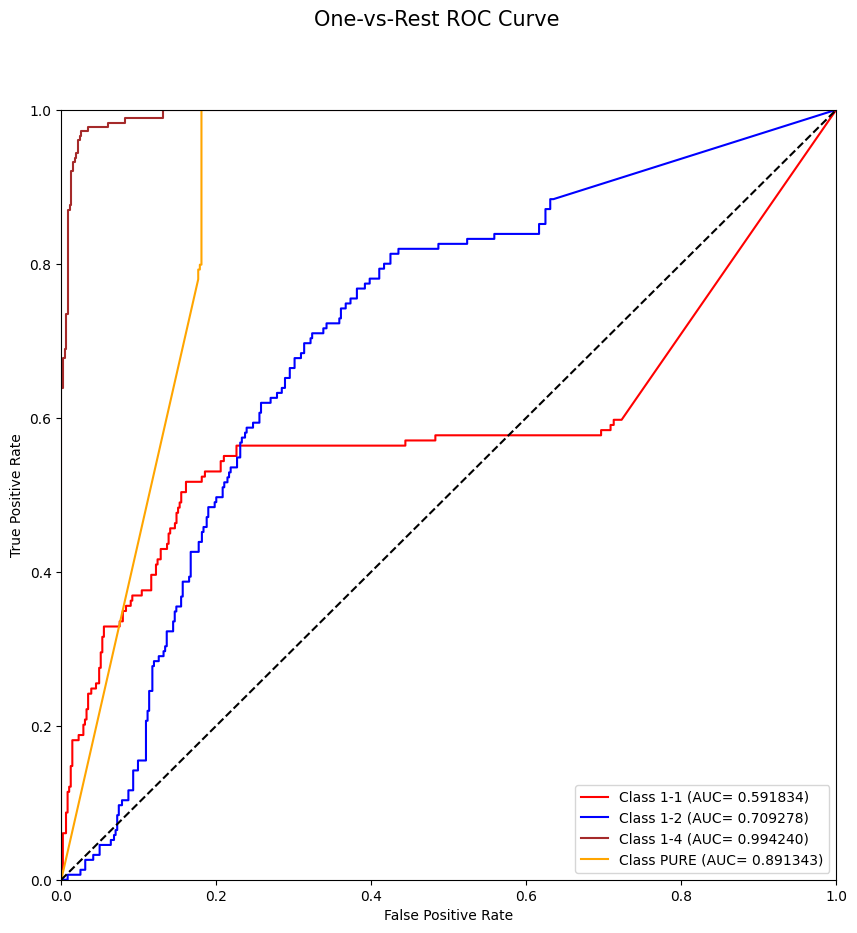

In [174]:
#Plotting the ROC Curve


fig=plt.figure(figsize=(10,10))
color=['red','blue','brown','orange']
for i in range(4):
  plt.plot(fpr[i],tpr[i],color[i],label='Class {} (AUC= {:.6F})'.format(CLASSES[i],roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('One-vs-Rest ROC Curve',fontsize=15)
plt.legend(loc='lower right')
plt.show()
fig.savefig('/content/drive/MyDrive/Project_2_Conference_Journal_Work/Conference_Journal_Extended_Work/RESNET50_ROC_AUC.eps', format='eps', dpi=600)

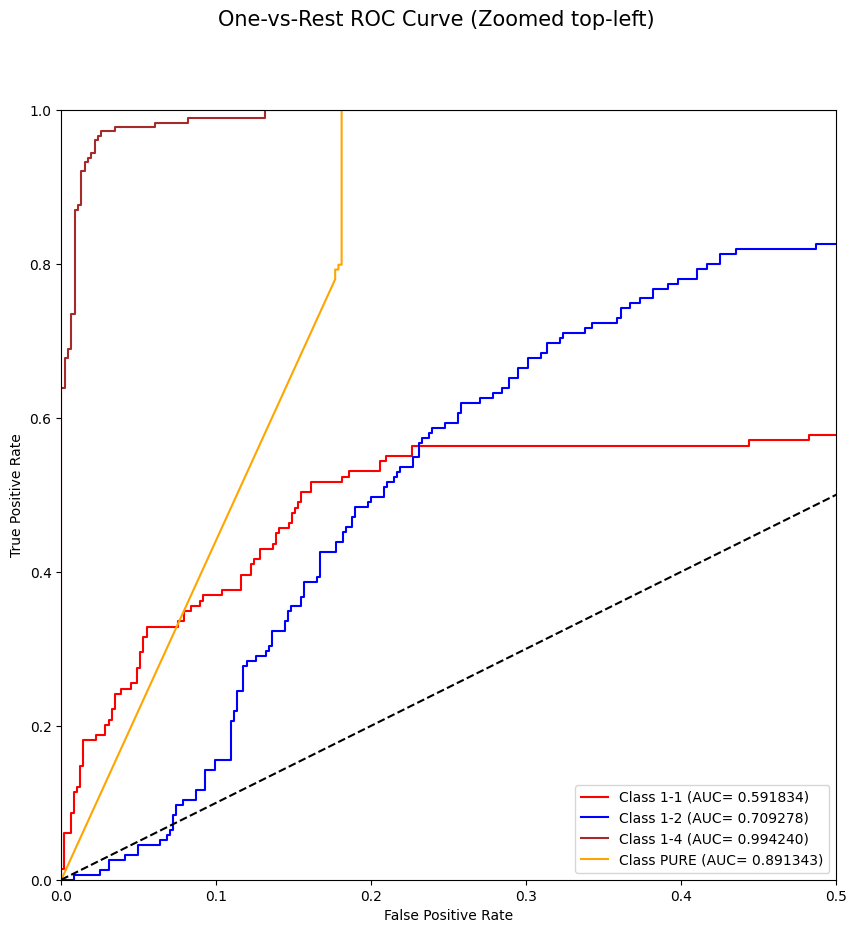

In [175]:
#Plotting the ROC Curve (Zoomed in at the top left corner)


fig=plt.figure(figsize=(10,10))
color=['red','blue','brown','orange']
for i in range(4):
  plt.plot(fpr[i],tpr[i],color[i],label='Class {} (AUC= {:.6F})'.format(CLASSES[i],roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 0.50])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('One-vs-Rest ROC Curve (Zoomed top-left)',fontsize=15)
plt.legend(loc='lower right')
plt.show()
fig.savefig('/content/drive/MyDrive/Project_2_Conference_Journal_Work/Conference_Journal_Extended_Work/RESNET50_ROC_AUC_Zoomed.eps', format='eps', dpi=600)

In [176]:
#Calculating the Log-loss Score (One-vs-Rest)


temp=[0]*4
loss=[0]*4
epsilon = 1e-15  # Small constant to avoid division by zero
N = Binarized_True_label.shape[0]

for i in range(4):
  # Clip predicted probabilities to avoid log(0) cases
  temp[i]= np.clip(Predicted_probabilities[:,i], epsilon, 1 - epsilon)
  # Calculate cross-entropy loss
  loss[i] = -np.sum(Binarized_True_label[:,i] * np.log(temp[i])) / N

In [177]:
log_loss_result=[]
for i in range(4):
  log_loss_result.append([CLASSES[i],loss[i]])

In [178]:
column_headers=['CLASS','LOG-LOSS VALUE']
print('Log-Loss Results')
print(tabulate(log_loss_result, headers=column_headers, tablefmt="grid"))

Log-Loss Results
+---------+------------------+
| CLASS   |   LOG-LOSS VALUE |
+=========+==================+
| 1-1     |       3.36604    |
+---------+------------------+
| 1-2     |       1.28375    |
+---------+------------------+
| 1-4     |       0.0244166  |
+---------+------------------+
| PURE    |       0.00115348 |
+---------+------------------+


In [179]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}, F Score: {f_score}, Cohen Kappa Score: {kappa}')

Precision: 0.8518518805503845, Recall: 0.9368635416030884, Accuracy: 0.75, F Score: 0.8923375808619172, Cohen Kappa Score: 0.6656763198276143


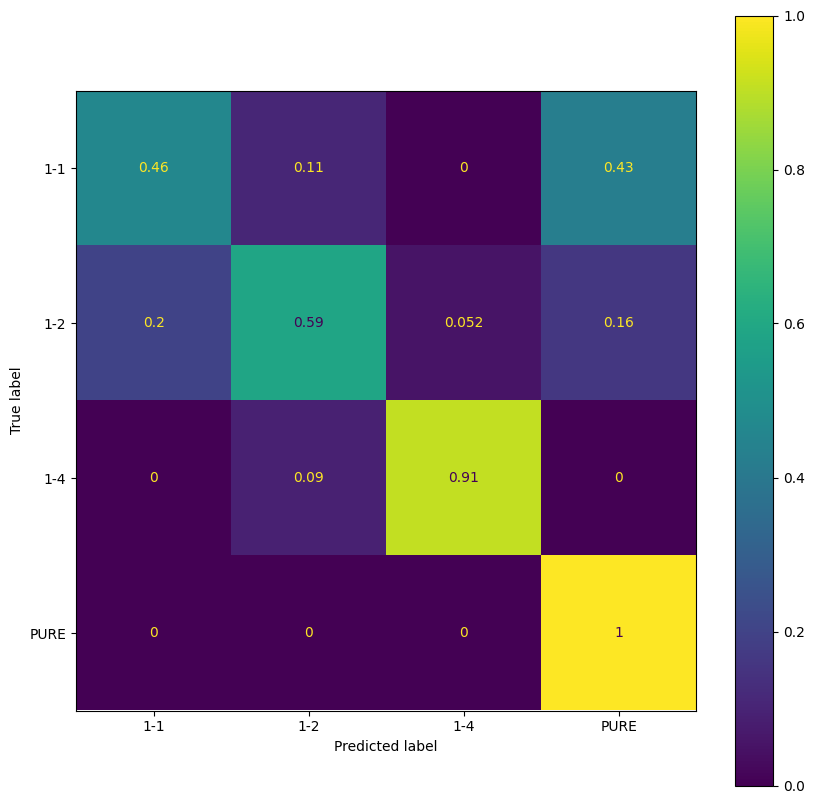

In [180]:
#Plotting the Confusion Matrix


confusion_matrix=metrics.confusion_matrix(True_label,Predicted_label,normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['1-1', '1-2','1-4','PURE'])
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
plt.show()
fig.savefig('/content/drive/MyDrive/Project_2_Conference_Journal_Work/Conference_Journal_Extended_Work/RESNET50_Confusion_Matrix.eps', format='eps', dpi=600)

# Training the EfficientNetB0 Model and evaluating the performance

In [201]:
from keras.applications import EfficientNetB0

In [202]:
efficientnetb0_logdir='/content/drive/MyDrive/Project_2_Conference_Journal_Work/Conference_Journal_Extended_Work/EFFICIENTNETB0_Logs'

In [203]:
efficientnetb0_tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=efficientnetb0_logdir)

In [204]:
efficientnetb0_base=EfficientNetB0(weights='imagenet',include_top=False,input_shape=(256,256,3))
efficientnetb0_model=Sequential()
efficientnetb0_model.add(efficientnetb0_base)
efficientnetb0_model.add(Flatten())
efficientnetb0_model.add(Dense(4,activation='sigmoid'))

efficientnetb0_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [205]:
efficientnetb0_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 8, 8, 1280)       4049571   
                                                                 
 flatten_6 (Flatten)         (None, 81920)             0         
                                                                 
 dense_9 (Dense)             (None, 4)                 327684    
                                                                 
Total params: 4,377,255
Trainable params: 4,335,232
Non-trainable params: 42,023
_________________________________________________________________


In [206]:
training_set=normalized_train_val_set.take(80)
validation_set=normalized_train_val_set.skip(80).take(20)

In [207]:
efficientnetb0_Training_start=time.time()

In [208]:
efficientnetb0_Model_Run=efficientnetb0_model.fit(
    training_set,
    validation_data=validation_set,
    epochs=30,
    steps_per_epoch=len(training_set),
    validation_steps=len(validation_set),
    callbacks=[efficientnetb0_tensorboard_callback]
)

Epoch 1/30
80/80 [==============================] - 70s 286ms/step - loss: 1.2157 - accuracy: 0.7633 - val_loss: 4.3866 - val_accuracy: 0.2469
Epoch 2/30
80/80 [==============================] - 21s 251ms/step - loss: 0.6881 - accuracy: 0.8844 - val_loss: 4.2148 - val_accuracy: 0.2281
Epoch 3/30
80/80 [==============================] - 20s 244ms/step - loss: 1.3680 - accuracy: 0.8766 - val_loss: 7.6283 - val_accuracy: 0.2500
Epoch 4/30
80/80 [==============================] - 21s 263ms/step - loss: 0.8182 - accuracy: 0.9187 - val_loss: 40.0706 - val_accuracy: 0.2313
Epoch 5/30
80/80 [==============================] - 22s 267ms/step - loss: 0.8964 - accuracy: 0.9430 - val_loss: 18.2808 - val_accuracy: 0.2500
Epoch 6/30
80/80 [==============================] - 20s 246ms/step - loss: 0.3056 - accuracy: 0.9680 - val_loss: 21.7813 - val_accuracy: 0.0250
Epoch 7/30
80/80 [==============================] - 21s 262ms/step - loss: 0.5409 - accuracy: 0.9594 - val_loss: 8.3606 - val_accuracy: 0.2

In [209]:
efficientnetb0_Training_stop=time.time()

In [210]:
print(f'Time requied for EFFICIENTNETB0 model training= {efficientnetb0_Training_stop-efficientnetb0_Training_start} seconds')

Time requied for EFFICIENTNETB0 model training= 943.5055775642395 seconds


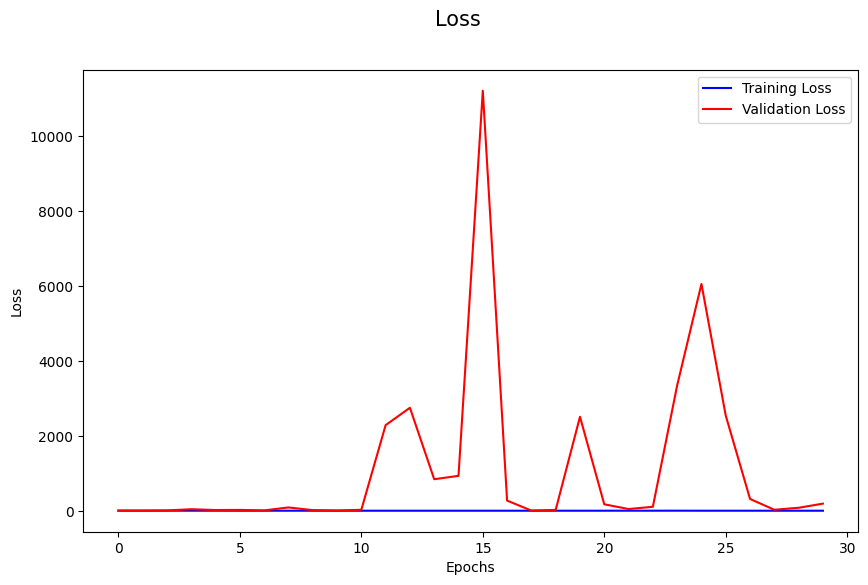

In [211]:
# Plotting the loss


fig=plt.figure(figsize=(10,6))
plt.plot(efficientnetb0_Model_Run.history['loss'], color='blue', label='Training Loss')
plt.plot(efficientnetb0_Model_Run.history['val_loss'], color='red', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
fig.suptitle('Loss',fontsize=15)
plt.legend()
plt.show()
fig.savefig('/content/drive/MyDrive/Project_2_Conference_Journal_Work/Conference_Journal_Extended_Work/EFFICIENTNETB0_Loss.eps', format='eps', dpi=600)

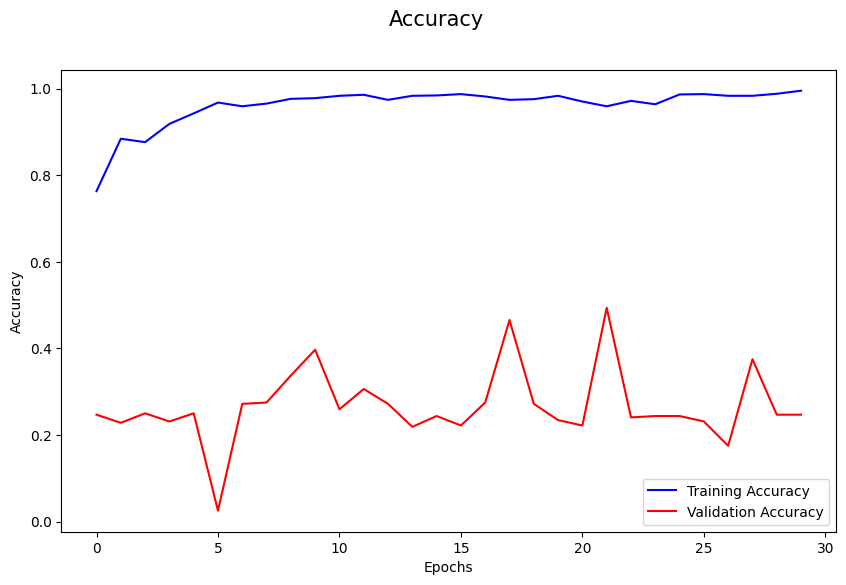

In [212]:
# Plotting the accuracy


fig=plt.figure(figsize=(10,6))
plt.plot(efficientnetb0_Model_Run.history['accuracy'], color='blue', label='Training Accuracy')
plt.plot(efficientnetb0_Model_Run.history['val_accuracy'], color='red', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
fig.suptitle('Accuracy',fontsize=15)
plt.legend()
plt.show()
fig.savefig('/content/drive/MyDrive/Project_2_Conference_Journal_Work/Conference_Journal_Extended_Work/EFFICIENTNETB0_Accuracy.eps', format='eps', dpi=600)

In [213]:
# Calculating the Precision, Recall, Accuracy

pre = Precision()
re = Recall()
acc = Accuracy()

In [214]:
True_label=[]
Predicted_label=[]
Predicted_probabilities=[]
score=[]
for images,labels in (normalized_testing_set):
  score.append(efficientnetb0_model.evaluate(images,labels))
  for it in range(len(labels)):
    True_label.append(labels[it])
  pred=efficientnetb0_model.predict(images)
  y_max=[]
  for it in range(len(pred)):
      Predicted_probabilities.append(pred[it])
      y_max.append(np.argmax(pred[it]))
      Predicted_label.append(np.argmax(pred[it]))
  pre.update_state(labels,y_max)
  re.update_state(labels,y_max)
  acc.update_state(labels,y_max)

1/1 [==============================] - 0s 34ms/step


In [215]:
f_score=(2*pre.result().numpy()*re.result().numpy())/(pre.result().numpy()+re.result().numpy())

In [216]:
kappa=cohen_kappa_score(True_label,Predicted_label)

In [217]:
True_label=np.array(True_label)
Predicted_label=np.array(Predicted_label)
Predicted_probabilities=np.array(Predicted_probabilities)

In [218]:
Binarized_True_label=label_binarize(True_label,classes=[0, 1, 2, 3])

In [219]:
#Calcualting the fpr, tpr and auc


fpr = [0] * 4
tpr = [0] * 4
roc_auc= [0] * 4
avg_roc_auc=0
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(Binarized_True_label[:, i], Predicted_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [220]:
roc_auc_details=[]
for i in range(4):
  temp=[CLASSES[i],roc_auc[i]]
  roc_auc_details.append(temp)

In [221]:
column_headers=['CLASS','ROC-AUC']
print('ROC-AUC Results')
print(tabulate(roc_auc_details, headers=column_headers, tablefmt="grid"))

ROC-AUC Results
+---------+-----------+
| CLASS   |   ROC-AUC |
+=========+===========+
| 1-1     |  0.5      |
+---------+-----------+
| 1-2     |  0.533919 |
+---------+-----------+
| 1-4     |  0.5      |
+---------+-----------+
| PURE    |  0.392128 |
+---------+-----------+


In [222]:
avg_roc_auc=sum(roc_auc)/4

In [223]:
print(f'The average ROC-AUC value is: {avg_roc_auc}')

The average ROC-AUC value is: 0.4815117466451269


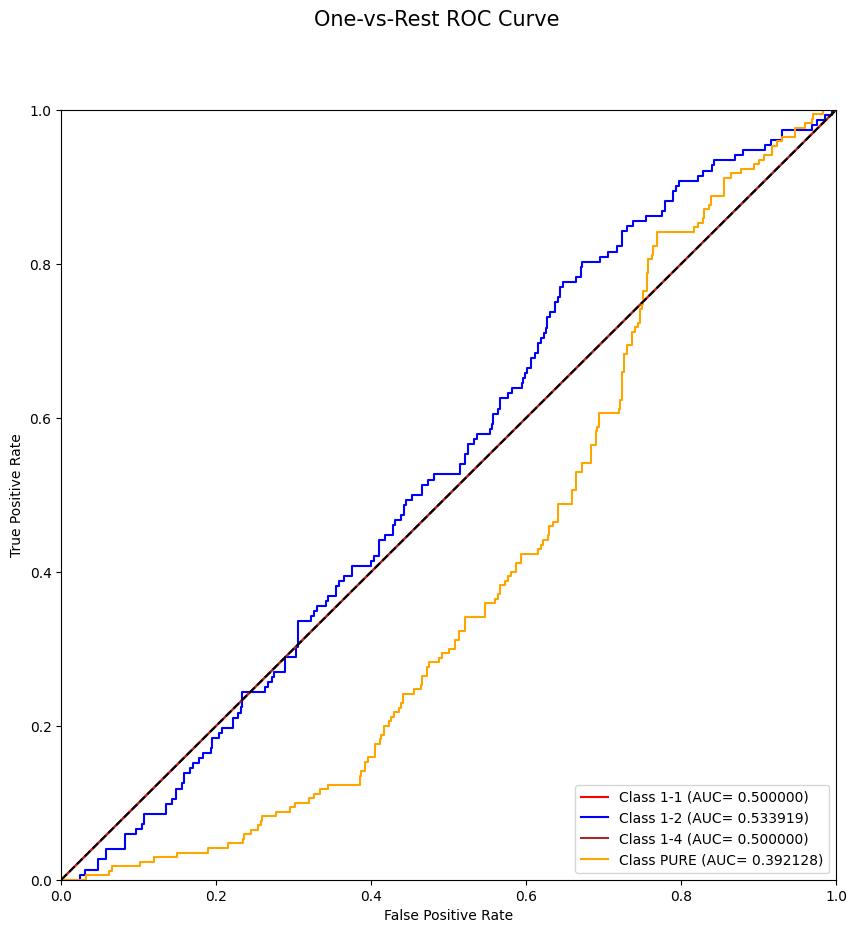

In [224]:
#Plotting the ROC Curve


fig=plt.figure(figsize=(10,10))
color=['red','blue','brown','orange']
for i in range(4):
  plt.plot(fpr[i],tpr[i],color[i],label='Class {} (AUC= {:.6F})'.format(CLASSES[i],roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('One-vs-Rest ROC Curve',fontsize=15)
plt.legend(loc='lower right')
plt.show()
fig.savefig('/content/drive/MyDrive/Project_2_Conference_Journal_Work/Conference_Journal_Extended_Work/EFFICIENTNETB0_ROC_AUC.eps', format='eps', dpi=600)

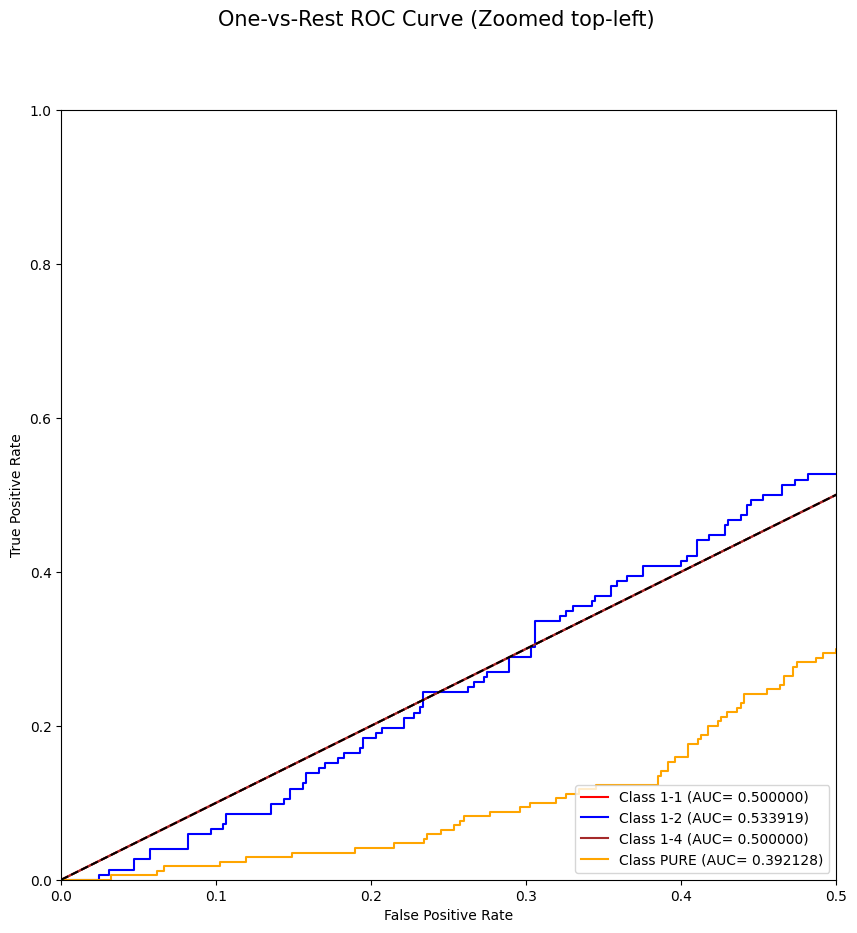

In [225]:
#Plotting the ROC Curve (Zoomed in at the top left corner)


fig=plt.figure(figsize=(10,10))
color=['red','blue','brown','orange']
for i in range(4):
  plt.plot(fpr[i],tpr[i],color[i],label='Class {} (AUC= {:.6F})'.format(CLASSES[i],roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 0.50])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.suptitle('One-vs-Rest ROC Curve (Zoomed top-left)',fontsize=15)
plt.legend(loc='lower right')
plt.show()
fig.savefig('/content/drive/MyDrive/Project_2_Conference_Journal_Work/Conference_Journal_Extended_Work/EFFICIENTNETB0_ROC_AUC_Zoomed.eps', format='eps', dpi=600)

In [226]:
#Calculating the Log-loss Score (One-vs-Rest)


temp=[0]*4
loss=[0]*4
epsilon = 1e-15  # Small constant to avoid division by zero
N = Binarized_True_label.shape[0]

for i in range(4):
  # Clip predicted probabilities to avoid log(0) cases
  temp[i]= np.clip(Predicted_probabilities[:,i], epsilon, 1 - epsilon)
  # Calculate cross-entropy loss
  loss[i] = -np.sum(Binarized_True_label[:,i] * np.log(temp[i])) / N

In [227]:
log_loss_result=[]
for i in range(4):
  log_loss_result.append([CLASSES[i],loss[i]])

In [228]:
column_headers=['CLASS','LOG-LOSS VALUE']
print('Log-Loss Results')
print(tabulate(log_loss_result, headers=column_headers, tablefmt="grid"))

Log-Loss Results
+---------+------------------+
| CLASS   |   LOG-LOSS VALUE |
+=========+==================+
| 1-1     |          8.41883 |
+---------+------------------+
| 1-2     |          7.9267  |
+---------+------------------+
| 1-4     |         -0       |
+---------+------------------+
| PURE    |          9.17436 |
+---------+------------------+


In [229]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}, F Score: {f_score}, Cohen Kappa Score: {kappa}')

Precision: 0.7562500238418579, Recall: 1.0, Accuracy: 0.25312501192092896, F Score: 0.8612099798723815, Cohen Kappa Score: 0.0


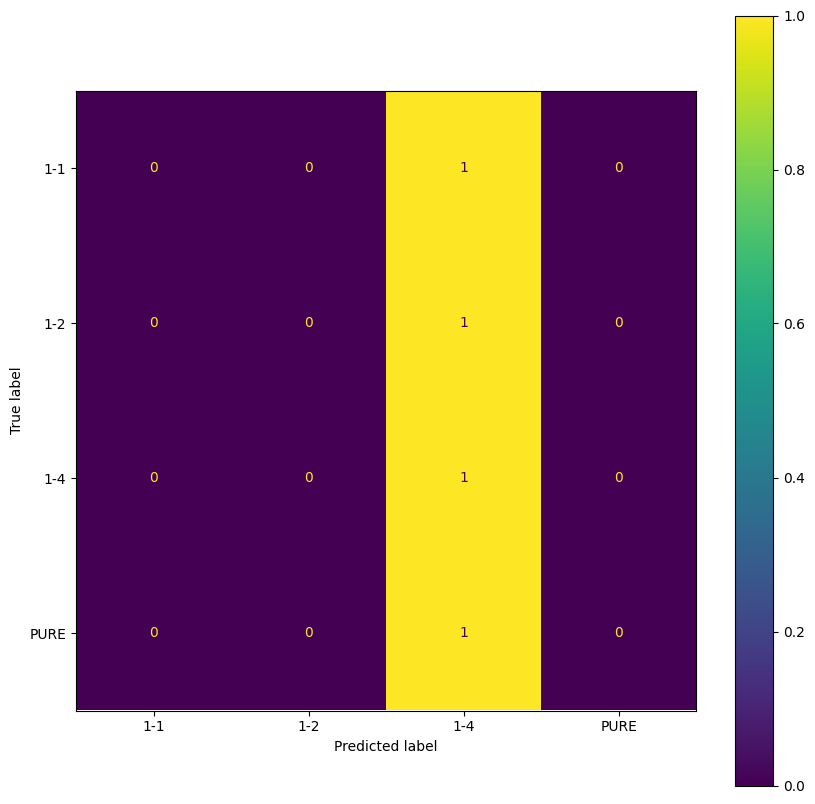

In [230]:
#Plotting the Confusion Matrix


confusion_matrix=metrics.confusion_matrix(True_label,Predicted_label,normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['1-1', '1-2','1-4','PURE'])
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
plt.show()
fig.savefig('/content/drive/MyDrive/Project_2_Conference_Journal_Work/Conference_Journal_Extended_Work/EFFICIENTNETB0_Confusion_Matrix.eps', format='eps', dpi=600)